# MSE Visualization

## 0. Import Libraries 
In this project I use **Pyvista** for 3D Visualization. Check out this website for more information: https://pyvista.org/ ! They also created a tutorial which is in this link: https://tutorial.pyvista.org/tutorial.html. 

The 2D graphs are visualized using **mpl_toolkits.mplot3d** for 2D Visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv  
pv.set_jupyter_backend('trame') 
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import marching_cubes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import LightSource
from matplotlib import animation

import ipywidgets as widgets
from IPython.display import display

## 1. Functions to calculate quadratic surface
These functions are defined specifically for the MSE visualization project. 

In [2]:

def E(u,Q):
    """
    Compute a shifted quadratic form E(u, Q) = sqrt(u)ᵀ Q sqrt(u) − 1.

    Parameters
    ----------
    u : shape (n, n, n, 3) 
        Mesh grid in the 3D space
        

    Q : shape (3, 3)
        A square matrix of size 3×3 representing the quadratic form.

    Returns
    sqrt(u)ᵀ Q sqrt(u) − 1
    -------
    
    """
    quad_vals = np.einsum('...i,ij,...j->...', np.sqrt(u), Q, np.sqrt(u))
    return quad_vals - 1.0

def E123(u,Q1,Q2, Q3):
    """
    Compute a shifted quadratic form E(u, Q) = sqrt(u)ᵀ Q sqrt(u) − 1.
    
    Parameters
    ----------
    u : shape (n, n, n, 3) 
    Mesh grid in the 3D space
    
    
    Q1/Q2/Q3 : shape (3, 3)
    A square matrix of size 3×3 representing the quadratic form.
    
    
    Returns
    (sqrt(u)ᵀ Q1 sqrt(u) − 1)^2 + (sqrt(u)ᵀ Q2 sqrt(u) − 1)^2 + (sqrt(u)ᵀ Q3 sqrt(u) − 1)^2
    -------
    
    """
    quad_vals1 = np.einsum('...i,ij,...j->...', np.sqrt(u), Q1, np.sqrt(u))
    quad_vals2 = np.einsum('...i,ij,...j->...', np.sqrt(u), Q2, np.sqrt(u))
    quad_vals3 = np.einsum('...i,ij,...j->...', np.sqrt(u), Q3, np.sqrt(u))

    return (quad_vals1 -1)^2 + (quad_vals2 -1)^2 + (quad_vals3 -1)^2
    
def Q_Matrix(Y):
    """
    Compute Q matrix using Y
    
    Parameters
    ----------
    Y : shape (3, 3) 
    Labels from dataset 
    
    
    Returns    
    Q1,Q2,Q3,Q4 : shape (3, 3)
    -------
    
    """
    G = Y.T@Y
    Q = np.linalg.inv(G)
    D1 = np.array([[1,0,0],
          [0,1,0],
          [0,0,1]
    ])
    D2 = np.array([[-1,0,0],
          [0,1,0],
          [0,0,1]
    ])
    D3 = np.array([[1,0,0],
          [0,-1,0],
          [0,0,1]
    ])
    D4 = np.array([[1,0,0],
          [0,1,0],
          [0,0,-1]
    ])
    D5 = np.array([[-1,0,0],
          [0,-1,0],
          [0,0,1]
    ])
    D6 = np.array([[1,0,0],
          [0,-1,0],
          [0,0,-1]
    ])
    D7 = np.array([[-1,0,0],
          [0,1,0],
          [0,0,-1]
    ])
    D8 = np.array([[-1,0,0],
          [0,-1,0],
          [0,0,-1]
    ])
    Q1 = D1@Q@D1
    Q2 = D2@Q@D2
    Q3 = D3@Q@D3
    Q4 = D4@Q@D4
    Q5 = D5@Q@D5
    Q6 = D6@Q@D6
    Q7 = D7@Q@D7
    Q8 = D8@Q@D8
    return Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8

## 2. Plotting Function for 2D & 3D plots

In [3]:
def plot_2D(ax, delta_x, delta_y, delta_z, u, Q, color):
    """
    Render the zero‐level isosurface of a quadratic‐form field on a 3D axes.

    Parameters
    ----------
    ax : mpl_toolkits.mplot3d.axes3d.Axes3D
        The target 3D axes on which to add the mesh.
    delta_x, delta_y, delta_z : float
        spacing along the x, y, and z axes, respectively.
    u : shape (n, n, n, 3) 
        Mesh grid in the 3D space
    Q : shape (3, 3)
        A square matrix of size 3×3 representing the quadratic form.
    color : color

    Returns
    -------
    verts : 
        Coordinates of the extracted surface vertices.
    faces : 
        Indices of triangular faces connecting the vertices.
    """
    
    values = E(u,Q)
    spacing = (delta_x, delta_y, delta_z)
    verts, faces, normals, _ = marching_cubes(
        values, level=0, spacing=spacing
    )
    
    mesh = Poly3DCollection(verts[faces])
    mesh.set_alpha(0.5)        
    mesh.set_facecolor(color)  
    
    ax.add_collection3d(mesh)
    return verts, faces


def plot_3D(plotter, verts, faces, color):
    """
    Plot a 3D mesh using PyVista Plotter.
    
    Parameters
    ----------
    plotter : pyvista.Plotter
    The PyVista Plotter instance to which the mesh will be added.
    verts : 
    Coordinates of the extracted surface vertices.
    faces : 
    Indices of triangular faces connecting the vertices.
    color : color
    
    Returns
    -------
    mesh : pyvista.PolyData
    The constructed triangular mesh that was added to the plotter.
    """
    n_faces = faces.shape[0]
    faces_prefixed = np.hstack([
    np.full((n_faces, 1), 3, dtype=np.int64),
    faces.astype(np.int64)
    ])
    faces_flat = faces_prefixed.ravel()
    m = pv.PolyData(verts, faces_flat)
    plotter.add_mesh(m, color, opacity=0.6)


# 3. Generate 2D & 3D plot for MSE visualization

In [4]:
def plot_generation_2D(Y):
    # 1. Build four Q Matrix from Y
    Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8 = Q_Matrix(Y)

    # 2. Create grid points in 3D space
    grid_min, grid_max = 0, 30.0
    points = 90  # Number of points in each dimension
    xs = np.linspace(grid_min, grid_max, points)
    ys = np.linspace(grid_min, grid_max, points)
    zs = np.linspace(grid_min, grid_max, points)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing='xy')
    u = np.stack((X, Y, Z), axis=-1)
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 3. Compute spacing for marching_cubes
    delta_x = xs[1] - xs[0]
    delta_y = ys[1] - ys[0]
    delta_z = zs[1] - zs[0]
    
    # 4. 2D plot generation
    verts1, faces1 = plot_2D(ax, delta_x, delta_y, delta_z, u, Q1, 'brown')
    verts2, faces2 = plot_2D(ax, delta_x, delta_y, delta_z, u, Q2, 'blue')
    verts3, faces3 = plot_2D(ax, delta_x, delta_y, delta_z, u, Q3, 'green')
    verts4, faces4 = plot_2D(ax, delta_x, delta_y, delta_z, u, Q4, 'pink')
    verts5, faces5 = plot_2D(ax, delta_x, delta_y, delta_z, u, Q5, 'yellow')
    verts6, faces6 = plot_2D(ax, delta_x, delta_y, delta_z, u, Q6, 'green')
    verts7, faces7 = plot_2D(ax, delta_x, delta_y, delta_z, u, Q7, 'red')
    verts8, faces8 = plot_2D(ax, delta_x, delta_y, delta_z, u, Q8, 'gray')
        
    # 5. Set axis range in "real" units, not just the voxel indices
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_zlim(0, 5)
    ax.view_init(elev=0, azim=70) 
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Isosurface of x^T Q x = 1")
    plt.show()

    #6. 3D visualization of quadratic surface
    plotter = pv.Plotter()
    plot_3D(plotter, verts1, faces1, 'blue')
    plot_3D(plotter, verts2, faces2, 'pink')
    plot_3D(plotter, verts3, faces3, 'green')
    plot_3D(plotter, verts4, faces4, 'blue')
    plot_3D(plotter, verts5, faces5, 'pink')
    plot_3D(plotter, verts6, faces6, 'green')
    plot_3D(plotter, verts7, faces7, 'red')
    plot_3D(plotter, verts8, faces8, 'gray')

    
    bounds = plotter.bounds             
    
    plotter.show_bounds(
        bounds=bounds,                    # ensure axes span full mesh
        axes_ranges=bounds,               # explicit tick ranges
        show_xaxis=True, show_yaxis=True, show_zaxis=True,
        n_xlabels=5, n_ylabels=5, n_zlabels=5,
        bold=True, font_size=12
    )
    
    plotter.show()
    plotter.enable_trackball_style() 
    return

# 4. Paret Front 3-D Visualization

In [5]:
def plot_Pareto(Y):
    Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8 = Q_Matrix(Y)
    
    plotter = pv.Plotter()

    grid_min, grid_max = 0, 10
    points = 500  # Number of points in each dimension
    xs = np.linspace(grid_min, grid_max, points)
    ys = np.linspace(grid_min, grid_max, points)
    zs = np.linspace(grid_min, grid_max, points)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing='xy')
    u = np.stack((X, Y, Z), axis=-1)
    
    F1 = E(u, Q1)   # negative inside quadric 1
    F2 = E(u, Q2)
    F3 = E(u, Q3)
    F4 = E(u, Q4)   
    F5 = E(u, Q5)
    F6 = E(u, Q6)
    F7 = E(u, Q7)
    F8 = E(u, Q8)
    
    # 2) make a mask of the common volume
    inside_all = (F1 <= 0) & (F2 <= 0) & (F3 <= 0) & (F4 <= 0) & (F5 <= 0) & (F6 <= 0) & (F7 <= 0) & (F8 <= 0)
    mask       = inside_all.astype(float)
    
    verts4, faces4, normals, _ = marching_cubes(mask, level=0,
                                             spacing = (xs[1] - xs[0], ys[1] - ys[0], zs[1] - zs[0]))
    
    #plot4
    n_faces = faces4.shape[0]
    faces_prefixed4 = np.hstack([
        np.full((n_faces, 1), 3, dtype=np.int64),
        faces4.astype(np.int64)
    ])
    faces_flat4 = faces_prefixed4.ravel()
    m4 = pv.PolyData(verts4, faces_flat4)
    plotter.add_mesh(m4, color='green', opacity=0.6)
    bounds = plotter.bounds               # (xmin,xmax,ymin,ymax,zmin,zmax) :contentReference[oaicite:1]{index=1}
    
    plotter.show_bounds(
        bounds=bounds,                    # ensure axes span full mesh
        axes_ranges=bounds,               # explicit tick ranges
        show_xaxis=True, show_yaxis=True, show_zaxis=True,
        n_xlabels=5, n_ylabels=5, n_zlabels=5,
        bold=True, font_size=12
    )
    
    plotter.show()
    plotter.enable_trackball_style() 
    return

In [12]:
def plot_Pareto_with_data(Y, points):
    Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8 = Q_Matrix(Y)
    
    plotter = pv.Plotter()
    plotter.add_points(points, color='blue', point_size=5.0, render_points_as_spheres=True)
    grid_min, grid_max = 0, 10
    points = 500  # Number of points in each dimension
    xs = np.linspace(grid_min, grid_max, points)
    ys = np.linspace(grid_min, grid_max, points)
    zs = np.linspace(grid_min, grid_max, points)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing='xy')
    u = np.stack((X, Y, Z), axis=-1)
    
    F1 = E(u, Q1)   # negative inside quadric 1
    F2 = E(u, Q2)
    F3 = E(u, Q3)
    F4 = E(u, Q4)   
    F5 = E(u, Q5)
    F6 = E(u, Q6)
    F7 = E(u, Q7)
    F8 = E(u, Q8)
    
    # 2) make a mask of the common volume
    inside_all = (F1 <= 0) & (F2 <= 0) & (F3 <= 0) & (F4 <= 0) & (F5 <= 0) & (F6 <= 0) & (F7 <= 0) & (F8 <= 0)
    mask       = inside_all.astype(float)
    
    verts4, faces4, normals, _ = marching_cubes(mask, level=0,
                                             spacing = (xs[1] - xs[0], ys[1] - ys[0], zs[1] - zs[0]))
    
    #plot4
    n_faces = faces4.shape[0]
    faces_prefixed4 = np.hstack([
        np.full((n_faces, 1), 3, dtype=np.int64),
        faces4.astype(np.int64)
    ])
    faces_flat4 = faces_prefixed4.ravel()
    m4 = pv.PolyData(verts4, faces_flat4)
    plotter.add_mesh(m4, color='green', opacity=0.6)
    bounds = plotter.bounds               # (xmin,xmax,ymin,ymax,zmin,zmax) :contentReference[oaicite:1]{index=1}
    
    plotter.show_bounds(
        bounds=bounds,                    # ensure axes span full mesh
        axes_ranges=bounds,               # explicit tick ranges
        show_xaxis=True, show_yaxis=True, show_zaxis=True,
        n_xlabels=5, n_ylabels=5, n_zlabels=5,
        bold=True, font_size=12
    )
    
    plotter.show()
    plotter.enable_trackball_style() 
    return

# 5.Test using different Y

## 5.1 Test 1

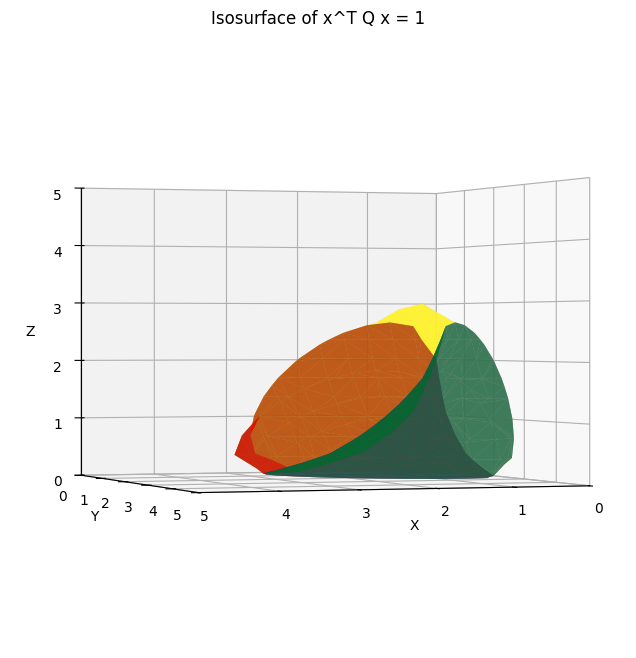

Widget(value='<iframe src="http://localhost:56452/index.html?ui=P_0x275106d6a50_0&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:56452/index.html?ui=P_0x27517ba4550_1&reconnect=auto" class="pyvis…

 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'
 JS Error => error: Uncaught SyntaxError: Unexpected token ')'


In [ ]:
Y = np.array([[1,-1,-1],
              [-1,1,-1],
              [-1,-1,1]  
])
plot_generation_2D(Y)
plot_Pareto(Y)

## 5.2 Test2

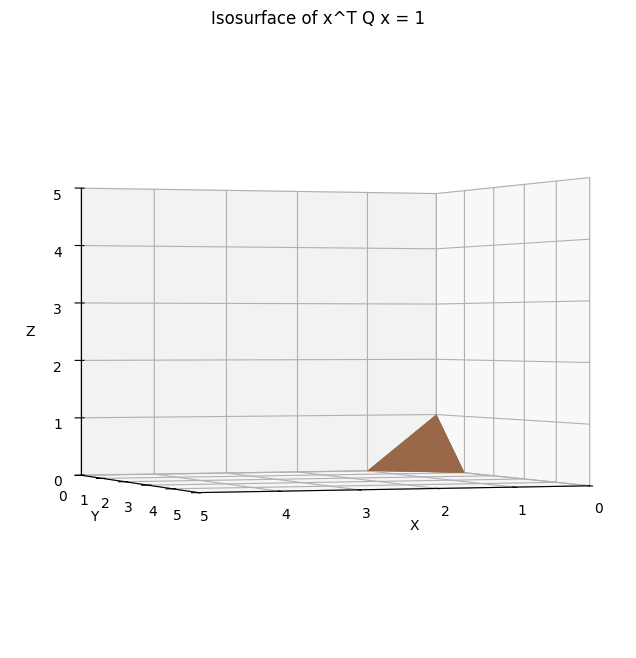

Widget(value='<iframe src="http://localhost:56452/index.html?ui=P_0x275137acf50_2&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:56452/index.html?ui=P_0x2751381d810_3&reconnect=auto" class="pyvis…

In [8]:
Y = np.array([[1,0,0],
              [0,1,0],
              [0,0,1]  
])
plot_generation_2D(Y)
plot_Pareto(Y)

## 5.3 Test3

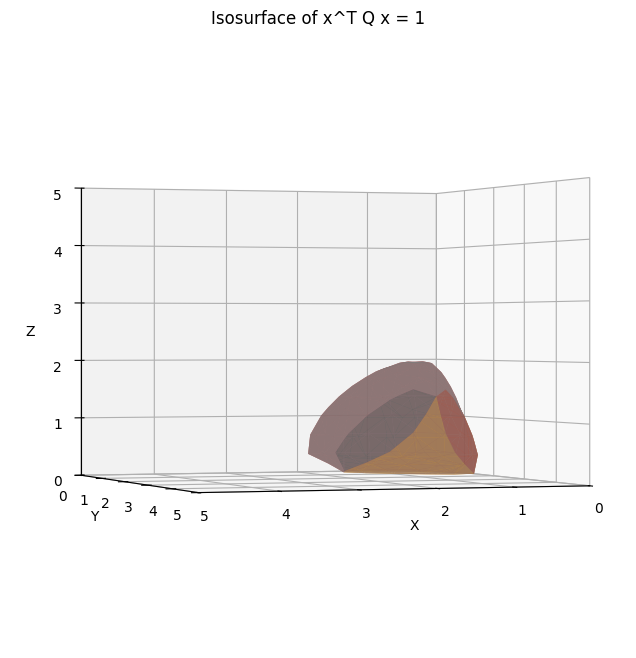

Widget(value='<iframe src="http://localhost:56452/index.html?ui=P_0x27513fd3b10_4&reconnect=auto" class="pyvis…

Widget(value='<iframe src="http://localhost:56452/index.html?ui=P_0x27513fd3c50_5&reconnect=auto" class="pyvis…

In [9]:
Y = np.array([[1,0,1],
              [1,1,0],
              [0,1,1]  
])
plot_generation_2D(Y)
plot_Pareto(Y)

# 6. Multi-task Learning Model Training 

In [7]:
import torch
import torch.nn as nn

class MTLModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 1)
        )
        # Task-specific heads
        self.head1 = nn.Linear(1, 1)   
        self.head2 = nn.Linear(1, 1)
        self.head3 = nn.Linear(1, 1)

    def forward(self, x):
        shared_rep = self.shared(x)
        # print("x =", x)
        # print("shared_rep", shared_rep)
        out1 = self.head1(shared_rep)
        out2 = self.head2(shared_rep)
        out3 = self.head3(shared_rep)
        return out1, out2, out3
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
def loss_gen(a,b,c):
    num_epochs = 500
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
    
        pred1, pred2, pred3 = model(X)
        
        loss1 = loss_fn(pred1, Y0)
        loss2 = loss_fn(pred2, Y1)
        loss3 = loss_fn(pred3, Y2)

        # print("pred3", pred3)
        # print("Y2", Y2)
        # print("loss3", loss3)
        
        loss = a*loss1 + b*loss2 + c*loss3
    
        loss.backward()
        optimizer.step()
        # print("iteration = ", epoch, "loss1 = ", loss1, "loss2 =", loss2, "loss3 =", loss3)
    return loss1, loss2, loss3

# 7. Test
## 7.1 Training without label noise 

In [9]:
n = 300 # number of data

#Use Gram–Schmidt method to create orthognal columns of X

X1 = torch.randn(n,1).to(device)
X1 = X1 / torch.norm(X1)
v1 = torch.randn(n, 1).to(device)
v1_proj = (v1.T @ X1) / (X1.T @ X1) * X1
X2 = v1 - v1_proj
X2 = X2 / torch.norm(X2)
v2 = torch.randn(n, 1).to(device)
v2_proj1 = (v2.T @ X2) / (X2.T @ X2) * X2
v2_proj2 = (v2.T @ X1) / (X1.T @ X1) * X1
X3 = v2 - v2_proj1 - v2_proj2
X3 = X3 / torch.norm(X3)
X = torch.cat((X1, X2, X3), dim=1)

# Y0 = (X[:, 0] + torch.normal(0, 0.05, size=(n,), device=device)).unsqueeze(1)
# Y1 = (X[:, 1] + torch.normal(0, 0.05, size=(n,), device=device)).unsqueeze(1)
# Y2 = (X[:, 2] + torch.normal(0, 0.05, size=(n,), device=device)).unsqueeze(1)

#let Y1 = X1
Y0 = (X[:, 0] ).unsqueeze(1)
Y1 = (X[:, 1] ).unsqueeze(1)
Y2 = (X[:, 2] ).unsqueeze(1)

In [14]:
loss1_list = []
loss2_list = []
loss3_list = []

#iterate the training process for n times, to collect losses with different weighting factor
for i in range(200):
    model = MTLModel(input_dim=3).to(device)
    # print(next(model.parameters()).device)  # Should show 'cuda:0'
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

    loss_fn = nn.MSELoss()  # For regression
    para = torch.abs(torch.randn(3))

    a = para[0]
    b = para[1]
    c = para[2]
    total = a + b + c
    a_norm = a/total 
    b_norm = b/total 
    c_norm = c/total 
    loss1, loss2, loss3 = loss_gen(a_norm, b_norm, c_norm)
    # loss1, loss2, loss3 = loss_gen(0, 0, 1)
    loss1_list.append(loss1.item())
    loss2_list.append(loss2.item())
    loss3_list.append(loss3.item())

In [15]:
print(loss1_list)
print(loss2_list)
print(loss3_list)

[0.002943882253021002, 0.0023084962740540504, 0.003314636182039976, 0.001864809077233076, 0.00020366892567835748, 0.0002884032146539539, 0.002764540957286954, 0.0033304751850664616, 0.0014324011281132698, 0.003341834992170334, 0.0005582516314461827, 0.0038522311951965094, 0.002866328228265047, 0.0025607161223888397, 0.00031142064835876226, 0.0025794191751629114, 0.002614854369312525, 0.0021348323207348585, 3.526146610965952e-05, 0.0010899052722379565, 0.0006203528610058129, 0.002564905444160104, 9.608323307475075e-05, 0.003043093718588352, 0.0033486168831586838, 0.0009726874413900077, 0.0033284935634583235, 0.0011169521603733301, 0.0016561284428462386, 0.0004751885135192424, 7.380273018497974e-05, 0.00325096701271832, 0.0024086073972284794, 0.003528923261910677, 0.003331787185743451, 0.004874632693827152, 1.3437782797609543e-07, 0.0034238863736391068, 0.0009945206111297011, 3.117857704637572e-05, 0.00297816121019423, 0.0029174720402806997, 0.0031936003360897303, 0.001468146569095552, 0

In [16]:
#testing code
# for i in range(1):
#     model = MTLModel(input_dim=3).to(device)
#     # print(next(model.parameters()).device)  # Should show 'cuda:0'
#     optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
#     loss_fn = nn.MSELoss()  # For regression
#     para = torch.abs(torch.randn(3))
#     loss1, loss2, loss3 = loss_gen(0, 0, 1)

# # print(loss1, loss2, loss3)
# model(torch.tensor([1.0, 2.0, 3.0]).to(device))

In [10]:
X_item = X.detach().cpu().numpy()
Y0_item = Y0.detach().cpu().numpy()
Y1_item = Y1.detach().cpu().numpy()
Y2_item = Y2.detach().cpu().numpy()
Y_stack = np.hstack((Y0_item, Y1_item, Y2_item))
Y_hat = X_item@np.linalg.pinv(X_item.T@X_item)@X_item.T@Y_stack #calculate the optimal Y_hat we can achieve 

points = np.vstack((loss1_list, loss2_list, loss3_list)).T

NameError: name 'loss1_list' is not defined

In [19]:
plot_Pareto_with_data(Y_hat,points)

Widget(value='<iframe src="http://localhost:56452/index.html?ui=P_0x275b344ad50_6&reconnect=auto" class="pyvis…

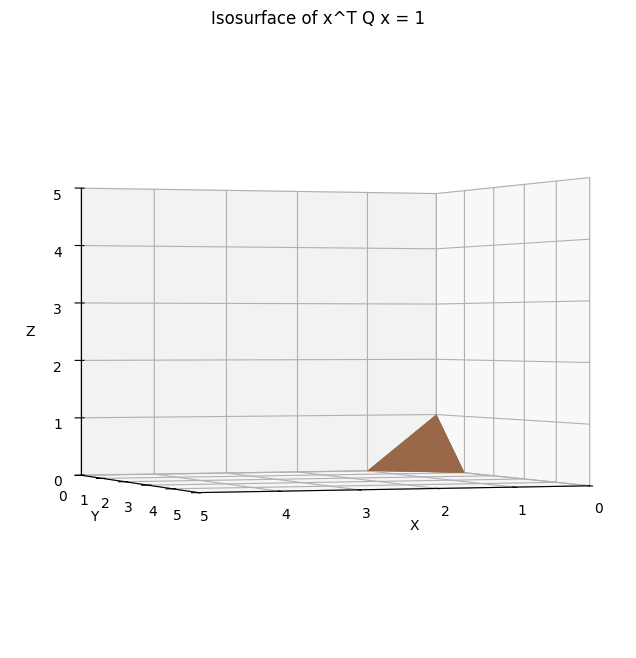

Widget(value='<iframe src="http://localhost:56452/index.html?ui=P_0x27595110690_7&reconnect=auto" class="pyvis…

In [20]:
plot_generation_2D(Y_hat)

In [21]:
points = np.vstack((loss1_list, loss2_list, loss3_list)).T
plotter = pv.Plotter()
plotter.add_points(points, color='blue', point_size=5.0, render_points_as_spheres=True)

plotter.show()

Widget(value='<iframe src="http://localhost:56452/index.html?ui=P_0x275951107d0_8&reconnect=auto" class="pyvis…

## 7.2 Training with label noise

In [13]:
Y0 = (X[:, 0] + torch.normal(0, 0.2, size=(n,), device=device)).unsqueeze(1)
Y1 = (X[:, 1] + torch.normal(0, 0.2, size=(n,), device=device)).unsqueeze(1)
Y2 = (X[:, 2] + torch.normal(0, 0.2, size=(n,), device=device)).unsqueeze(1)

In [14]:
loss1_rand_list = []
loss2_rand_list = []
loss3_rand_list = []
for i in range(1000):
    model = MTLModel(input_dim=3).to(device)
    # print(next(model.parameters()).device)  # Should show 'cuda:0'
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

    loss_fn = nn.MSELoss()  # For regression
    para = torch.abs(torch.randn(3))

    a = para[0]
    b = para[1]
    c = para[2]
    total = a + b + c
    a_norm = a/total 
    b_norm = b/total 
    c_norm = c/total 
    loss1, loss2, loss3 = loss_gen(a_norm, b_norm, c_norm)
    # loss1, loss2, loss3 = loss_gen(0, 0, 1)
    loss1_rand_list.append(loss1.item())
    loss2_rand_list.append(loss2.item())
    loss3_rand_list.append(loss3.item())

In [15]:
X_item = X.detach().cpu().numpy()
Y0_item = Y0.detach().cpu().numpy()
Y1_item = Y1.detach().cpu().numpy()
Y2_item = Y2.detach().cpu().numpy()
Y_stack = np.hstack((Y0_item, Y1_item, Y2_item))
Y_hat = X_item@np.linalg.pinv(X_item.T@X_item)@X_item.T@Y_stack

points = np.vstack((loss1_rand_list, loss2_rand_list, loss3_rand_list)).T

In [18]:
plot_Pareto_with_data(Y_hat,points)

Widget(value='<iframe src="http://localhost:60193/index.html?ui=P_0x2ac2a857390_1&reconnect=auto" class="pyvis…

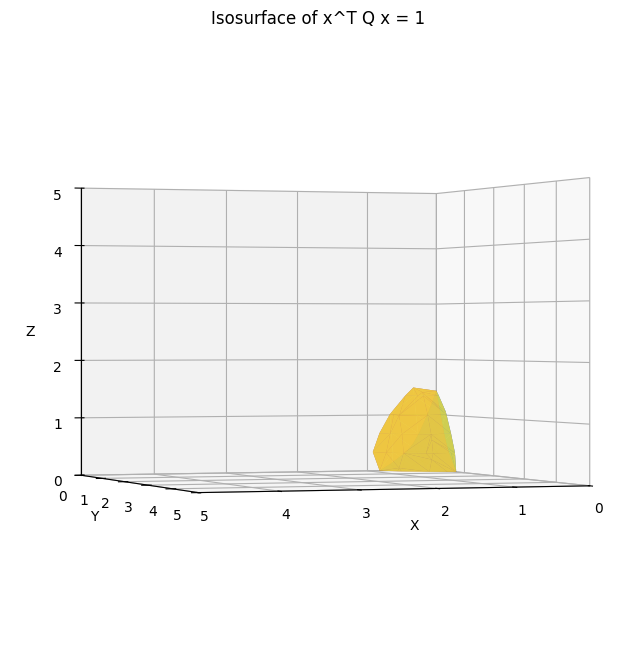

Widget(value='<iframe src="http://localhost:60193/index.html?ui=P_0x2ac80035810_2&reconnect=auto" class="pyvis…

In [19]:
plot_generation_2D(Y_hat)

In [17]:
points = np.vstack((loss1_rand_list, loss2_rand_list, loss3_rand_list)).T
plotter = pv.Plotter()
plotter.add_points(points, color='blue', point_size=5.0, render_points_as_spheres=True)

plotter.show()

Widget(value='<iframe src="http://localhost:60193/index.html?ui=P_0x2ac6fc55010_0&reconnect=auto" class="pyvis…